In [1]:
import matplotlib.pyplot as plt
import json

import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name='Crawler.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
#Actor and Critic Networks
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.elu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)

In [5]:
#Agent
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4 #3e-5 #1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4 #3e-5 #1e-4        # learning rate of the critic
WEIGHT_DECAY_actor = 0.0 #3e-4 #0        # L2 weight decay
WEIGHT_DECAY_critic = 0.0 #1e-6 #0        # L2 weight decay

#to decay exploration as it learns
EPS_START=1.0
EPS_END=0.05
EPS_DECAY=3e-5

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY_critic)

        # Noise process
        #self.noise = OUNoise(action_size, random_seed) #single agent only
        self.noise = OUNoise((num_agents, action_size), random_seed) #both singe and multiple agent
        self.eps = EPS_START

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
        # Make sure target is initialized with the same weight as the source (found on slack to make big difference)
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)


    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        #Experience from each agent is separately saved (so it works for single or multi agent environment)
        #This works because each agent is operating in a separate/independent environment
        for a in range(self.num_agents):
            self.memory.add(states[a], actions[a], rewards[a], next_states[a], dones[a])

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        #add noise according to epsilon probability
        if add_noise and (np.random.random() < self.eps):
            actions += self.noise.sample()
            #update the exploration parameter
            self.eps -= EPS_DECAY
            if self.eps < EPS_END:
                self.eps = EPS_END
            #self.noise.reset() #not sure if need to do this here

        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0) #clip the gradient for the critic network (Udacity hint)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


    ## from slack - Since you're using DDPG, @gregoriomezquita mentioned that 
    ## initializing the weights of the target networks to be the same as those 
    ## of the live networks seemed to make a huge difference
    def hard_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]
agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, 
              num_agents=env_info.vector_observations.shape[0],  random_seed=0)


#for single and multiple agents
def ddpg(n_episodes=2000):
    scores_deque = deque(maxlen=100)
    scores_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        agent.reset() #reset the agent OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get rewards (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent)
            agent.step(states, actions, rewards, next_states, dones) #train the agent
            
            # Extra Learning per time step (since generating so much experience at each step)
            if len(agent.memory) > BATCH_SIZE:
                for _ in range(3):
                    experiences = agent.memory.sample()
                    agent.learn(experiences, GAMMA)
            
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
            #print('Total score (averaged over agents) this episode: {}'.format(np.mean(score)))
        
        scores_deque.append(np.mean(scores))
        scores_list.append(np.mean(scores))
        
        #print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), score), end="")
        print('Episode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), np.mean(scores)))
        print('Epsilon: {} and Memory size: {}'.format(agent.eps, len(agent.memory)))
        
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) > 30 and len(scores_deque) >= 100:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
            
    return scores_list

Episode 1	Average Score: 0.30	Score: 0.3025603391385327
Epsilon: 0.9997600000000002 and Memory size: 96


/anaconda3/envs/openai/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 2	Average Score: 0.52	Score: 0.7369101606309414
Epsilon: 0.9992800000000006 and Memory size: 288
Episode 3	Average Score: 0.51	Score: 0.5023312895403554
Epsilon: 0.9990100000000008 and Memory size: 396
Episode 4	Average Score: 0.48	Score: 0.3806857606008028
Epsilon: 0.998770000000001 and Memory size: 492
Episode 5	Average Score: 0.33	Score: -0.25263318854073685
Epsilon: 0.9985300000000012 and Memory size: 588
Episode 6	Average Score: 0.18	Score: -0.6060565617711594
Epsilon: 0.9982900000000015 and Memory size: 684
Episode 7	Average Score: 0.09	Score: -0.4210340981371701
Epsilon: 0.9980500000000017 and Memory size: 780
Episode 8	Average Score: 0.01	Score: -0.5441680158643672
Epsilon: 0.9978100000000019 and Memory size: 876
Episode 9	Average Score: 0.03	Score: 0.20655928338722637
Epsilon: 0.9975700000000021 and Memory size: 972
Episode 10	Average Score: 0.08	Score: 0.5272528779072067
Epsilon: 0.9973000000000023 and Memory size: 1080
Episode 11	Average Score: 0.10	Score: 0.26168899

Episode 79	Average Score: 0.45	Score: 0.5656536937846491
Epsilon: 0.9759700000000204 and Memory size: 9696
Episode 80	Average Score: 0.46	Score: 0.5102060488813246
Epsilon: 0.9756100000000207 and Memory size: 9840
Episode 81	Average Score: 0.46	Score: 0.4394133852329105
Epsilon: 0.9751300000000211 and Memory size: 10032
Episode 82	Average Score: 0.46	Score: 0.7821678191345806
Epsilon: 0.9745900000000216 and Memory size: 10272
Episode 83	Average Score: 0.46	Score: 0.6283044189525148
Epsilon: 0.974170000000022 and Memory size: 10440
Episode 84	Average Score: 0.46	Score: 0.478294158858868
Epsilon: 0.9739000000000222 and Memory size: 10548
Episode 85	Average Score: 0.46	Score: 0.5581403023097664
Epsilon: 0.9736600000000224 and Memory size: 10644
Episode 86	Average Score: 0.47	Score: 0.9592090108975148
Epsilon: 0.9725800000000233 and Memory size: 11076
Episode 87	Average Score: 0.46	Score: -0.1855114938613648
Epsilon: 0.9721300000000237 and Memory size: 11268
Episode 88	Average Score: 0.46	

Episode 155	Average Score: 0.36	Score: -0.1808925193035975
Epsilon: 0.949390000000043 and Memory size: 20712
Episode 156	Average Score: 0.36	Score: 0.0029037952966367206
Epsilon: 0.9491500000000432 and Memory size: 20808
Episode 157	Average Score: 0.35	Score: 0.00518225331325084
Epsilon: 0.9489400000000434 and Memory size: 20904
Episode 158	Average Score: 0.34	Score: -0.21982451695172736
Epsilon: 0.9487300000000436 and Memory size: 21000
Episode 159	Average Score: 0.34	Score: -0.01617730176076293
Epsilon: 0.9484900000000438 and Memory size: 21096
Episode 160	Average Score: 0.33	Score: 0.022955670564745862
Epsilon: 0.948280000000044 and Memory size: 21180
Episode 161	Average Score: 0.32	Score: -0.2004655300406739
Epsilon: 0.9480700000000442 and Memory size: 21276
Episode 162	Average Score: 0.32	Score: -0.09722115161518256
Epsilon: 0.9478900000000443 and Memory size: 21360
Episode 163	Average Score: 0.31	Score: -0.16550177537525693
Epsilon: 0.9476500000000445 and Memory size: 21456
Episo

Episode 230	Average Score: 0.43	Score: 0.38315071219888824
Epsilon: 0.9287800000000606 and Memory size: 29472
Episode 231	Average Score: 0.43	Score: 0.2705854537974422
Epsilon: 0.9285700000000607 and Memory size: 29568
Episode 232	Average Score: 0.42	Score: 0.46171431623709697
Epsilon: 0.928300000000061 and Memory size: 29688
Episode 233	Average Score: 0.43	Score: 1.4492140199290588
Epsilon: 0.9278200000000614 and Memory size: 29880
Episode 234	Average Score: 0.43	Score: 0.4872968652828907
Epsilon: 0.9275800000000616 and Memory size: 29976
Episode 235	Average Score: 0.44	Score: 0.6978833364167562
Epsilon: 0.9272800000000618 and Memory size: 30108
Episode 236	Average Score: 0.44	Score: 1.2162562668866788
Epsilon: 0.9267100000000623 and Memory size: 30336
Episode 237	Average Score: 0.45	Score: 1.075009793237162
Epsilon: 0.9262900000000627 and Memory size: 30516
Episode 238	Average Score: 0.45	Score: 1.2295699435441445
Epsilon: 0.925930000000063 and Memory size: 30672
Episode 239	Average 

Episode 306	Average Score: 1.27	Score: 1.8389777538832277
Epsilon: 0.9049600000000808 and Memory size: 39552
Episode 307	Average Score: 1.28	Score: 1.5243909806789209
Epsilon: 0.904690000000081 and Memory size: 39660
Episode 308	Average Score: 1.28	Score: 0.8562673445558175
Epsilon: 0.9045400000000812 and Memory size: 39756
Episode 309	Average Score: 1.29	Score: 0.8966878110853335
Epsilon: 0.9043600000000813 and Memory size: 39840
Episode 310	Average Score: 1.29	Score: 1.6434212853976835
Epsilon: 0.9040600000000816 and Memory size: 39960
Episode 311	Average Score: 1.30	Score: 1.103691737051122
Epsilon: 0.9038200000000818 and Memory size: 40056
Episode 312	Average Score: 1.31	Score: 1.660942065063864
Epsilon: 0.903550000000082 and Memory size: 40176
Episode 313	Average Score: 1.31	Score: 0.9667352529553076
Epsilon: 0.9033700000000822 and Memory size: 40260
Episode 314	Average Score: 1.31	Score: 1.7440218418681372
Epsilon: 0.9030700000000824 and Memory size: 40380
Episode 315	Average Sco

Episode 382	Average Score: 1.78	Score: 2.034422221321923
Epsilon: 0.8837800000000988 and Memory size: 49068
Episode 383	Average Score: 1.78	Score: 1.7651144391080986
Epsilon: 0.8834800000000991 and Memory size: 49200
Episode 384	Average Score: 1.78	Score: 0.9476940739744654
Epsilon: 0.8832400000000993 and Memory size: 49296
Episode 385	Average Score: 1.75	Score: 1.2324849124221753
Epsilon: 0.8829400000000995 and Memory size: 49416
Episode 386	Average Score: 1.75	Score: 0.9346650175284594
Epsilon: 0.8827300000000997 and Memory size: 49512
Episode 387	Average Score: 1.75	Score: 2.212762389720107
Epsilon: 0.8824600000000999 and Memory size: 49656
Episode 388	Average Score: 1.75	Score: 0.8939532276320582
Epsilon: 0.8823100000001001 and Memory size: 49752
Episode 389	Average Score: 1.75	Score: 1.5420012935064733
Epsilon: 0.8820400000001003 and Memory size: 49872
Episode 390	Average Score: 1.75	Score: 0.785589246544987
Epsilon: 0.8818600000001005 and Memory size: 49968
Episode 391	Average Sc

Episode 458	Average Score: 3.74	Score: 1.0779963497382898
Epsilon: 0.8503000000001273 and Memory size: 64428
Episode 459	Average Score: 3.73	Score: 0.6913501415401697
Epsilon: 0.8501500000001274 and Memory size: 64512
Episode 460	Average Score: 3.75	Score: 2.950394959305413
Epsilon: 0.8498200000001277 and Memory size: 64656
Episode 461	Average Score: 3.78	Score: 4.849483507762973
Epsilon: 0.8493700000001281 and Memory size: 64860
Episode 462	Average Score: 3.83	Score: 5.5857008350236965
Epsilon: 0.8488900000001285 and Memory size: 65076
Episode 463	Average Score: 3.81	Score: 0.5711350063017259
Epsilon: 0.8487100000001286 and Memory size: 65160
Episode 464	Average Score: 3.87	Score: 7.960168860697498
Epsilon: 0.8482000000001291 and Memory size: 65424
Episode 465	Average Score: 3.87	Score: 1.929852943091343
Epsilon: 0.8479600000001293 and Memory size: 65532
Episode 466	Average Score: 3.90	Score: 4.95835420586324
Epsilon: 0.8475400000001296 and Memory size: 65724
Episode 467	Average Score

Episode 534	Average Score: 6.38	Score: 9.333497870946303
Epsilon: 0.8138800000001583 and Memory size: 81996
Episode 535	Average Score: 6.40	Score: 9.906306989995452
Epsilon: 0.8133700000001587 and Memory size: 82272
Episode 536	Average Score: 6.40	Score: 6.998557420680299
Epsilon: 0.8129200000001591 and Memory size: 82512
Episode 537	Average Score: 6.45	Score: 11.56309714804714
Epsilon: 0.8122900000001596 and Memory size: 82836
Episode 538	Average Score: 6.46	Score: 8.544608809015093
Epsilon: 0.8116900000001601 and Memory size: 83112
Episode 539	Average Score: 6.50	Score: 4.896222097333521
Epsilon: 0.8112400000001605 and Memory size: 83304
Episode 540	Average Score: 6.51	Score: 7.0912417738387985
Epsilon: 0.8107600000001609 and Memory size: 83532
Episode 541	Average Score: 6.51	Score: 7.916892359537694
Epsilon: 0.8102800000001613 and Memory size: 83784
Episode 542	Average Score: 6.50	Score: 3.1890210869411626
Epsilon: 0.8099800000001616 and Memory size: 83928
Episode 543	Average Score:

Episode 610	Average Score: 8.28	Score: 14.690763605409302
Epsilon: 0.7756000000001908 and Memory size: 100000
Episode 611	Average Score: 8.35	Score: 15.468971530984467
Epsilon: 0.7750300000001913 and Memory size: 100000
Episode 612	Average Score: 8.36	Score: 9.142731292871758
Epsilon: 0.7744900000001917 and Memory size: 100000
Episode 613	Average Score: 8.41	Score: 11.92677826123933
Epsilon: 0.7738000000001923 and Memory size: 100000
Episode 614	Average Score: 8.39	Score: 6.445394263020717
Epsilon: 0.7734400000001926 and Memory size: 100000
Episode 615	Average Score: 8.43	Score: 13.295707469068779
Epsilon: 0.7728100000001932 and Memory size: 100000
Episode 616	Average Score: 8.47	Score: 12.110124947774844
Epsilon: 0.7721800000001937 and Memory size: 100000
Episode 617	Average Score: 8.52	Score: 10.855506261694245
Epsilon: 0.7715500000001942 and Memory size: 100000
Episode 618	Average Score: 8.48	Score: 9.889279533080602
Epsilon: 0.7709500000001948 and Memory size: 100000
Episode 619	Av

Episode 685	Average Score: 11.06	Score: 12.134023019423088
Epsilon: 0.7296400000002299 and Memory size: 100000
Episode 686	Average Score: 11.11	Score: 10.83389819029253
Epsilon: 0.7291300000002303 and Memory size: 100000
Episode 687	Average Score: 11.08	Score: 11.245789260370657
Epsilon: 0.7284100000002309 and Memory size: 100000
Episode 688	Average Score: 11.10	Score: 8.813580218547335
Epsilon: 0.7278700000002314 and Memory size: 100000
Episode 689	Average Score: 11.09	Score: 10.32099500686551
Epsilon: 0.7272400000002319 and Memory size: 100000
Episode 690	Average Score: 11.05	Score: 9.324635553794602
Epsilon: 0.7266400000002324 and Memory size: 100000
Episode 691	Average Score: 11.03	Score: 12.534299163458249
Epsilon: 0.725980000000233 and Memory size: 100000
Episode 692	Average Score: 11.00	Score: 14.8277630750866
Epsilon: 0.7251100000002337 and Memory size: 100000
Episode 693	Average Score: 11.00	Score: 11.317697266562996
Epsilon: 0.7243600000002344 and Memory size: 100000
Episode 

Episode 760	Average Score: 12.54	Score: 17.129353653018672
Epsilon: 0.6810400000002712 and Memory size: 100000
Episode 761	Average Score: 12.61	Score: 18.416649535298347
Epsilon: 0.6802000000002719 and Memory size: 100000
Episode 762	Average Score: 12.69	Score: 16.144548554206267
Epsilon: 0.6794500000002726 and Memory size: 100000
Episode 763	Average Score: 12.73	Score: 14.950066532474011
Epsilon: 0.6788200000002731 and Memory size: 100000
Episode 764	Average Score: 12.76	Score: 13.508449774002656
Epsilon: 0.6781300000002737 and Memory size: 100000
Episode 765	Average Score: 12.85	Score: 16.864790925523266
Epsilon: 0.6772900000002744 and Memory size: 100000
Episode 766	Average Score: 12.93	Score: 18.249448194595363
Epsilon: 0.6766600000002749 and Memory size: 100000
Episode 767	Average Score: 12.95	Score: 13.039563339281207
Epsilon: 0.6760600000002754 and Memory size: 100000
Episode 768	Average Score: 12.98	Score: 16.658433584690403
Epsilon: 0.6752200000002762 and Memory size: 100000
E

Episode 835	Average Score: 14.00	Score: 15.917492231276507
Epsilon: 0.6397900000003063 and Memory size: 100000
Episode 836	Average Score: 14.01	Score: 12.708127352098623
Epsilon: 0.6393700000003066 and Memory size: 100000
Episode 837	Average Score: 13.98	Score: 12.900210916840782
Epsilon: 0.6388600000003071 and Memory size: 100000
Episode 838	Average Score: 13.99	Score: 10.176183973167403
Epsilon: 0.6385000000003074 and Memory size: 100000
Episode 839	Average Score: 13.98	Score: 8.82342796396309
Epsilon: 0.6381400000003077 and Memory size: 100000
Episode 840	Average Score: 14.04	Score: 15.55756872597461
Epsilon: 0.6376000000003081 and Memory size: 100000
Episode 841	Average Score: 14.00	Score: 14.118609224640144
Epsilon: 0.6371200000003086 and Memory size: 100000
Episode 842	Average Score: 14.06	Score: 16.43655080612128
Epsilon: 0.636550000000309 and Memory size: 100000
Episode 843	Average Score: 14.05	Score: 14.042522277333774
Epsilon: 0.6360700000003094 and Memory size: 100000
Episod

Episode 910	Average Score: 14.19	Score: 15.657037120351257
Epsilon: 0.6037300000003369 and Memory size: 100000
Episode 911	Average Score: 14.22	Score: 16.366215501911938
Epsilon: 0.6032200000003374 and Memory size: 100000
Episode 912	Average Score: 14.19	Score: 14.270320759232467
Epsilon: 0.6026800000003378 and Memory size: 100000
Episode 913	Average Score: 14.23	Score: 17.3736403574779
Epsilon: 0.6019900000003384 and Memory size: 100000
Episode 914	Average Score: 14.27	Score: 17.58966969011817
Epsilon: 0.6015100000003388 and Memory size: 100000
Episode 915	Average Score: 14.31	Score: 18.90438486561955
Epsilon: 0.6007900000003394 and Memory size: 100000
Episode 916	Average Score: 14.32	Score: 16.334540427584823
Epsilon: 0.60019000000034 and Memory size: 100000
Episode 917	Average Score: 14.36	Score: 15.856173681793734
Epsilon: 0.5996500000003404 and Memory size: 100000
Episode 918	Average Score: 14.36	Score: 15.684097687985437
Epsilon: 0.5990800000003409 and Memory size: 100000
Episode

Episode 985	Average Score: 14.93	Score: 12.055485080500754
Epsilon: 0.5678500000003674 and Memory size: 100000
Episode 986	Average Score: 14.95	Score: 14.882832533291852
Epsilon: 0.5674000000003678 and Memory size: 100000
Episode 987	Average Score: 15.01	Score: 12.690569992293604
Epsilon: 0.5669800000003682 and Memory size: 100000
Episode 988	Average Score: 14.92	Score: 6.4554160917953896
Epsilon: 0.5667100000003684 and Memory size: 100000
Episode 989	Average Score: 14.86	Score: 11.529597447253764
Epsilon: 0.5662000000003689 and Memory size: 100000
Episode 990	Average Score: 14.85	Score: 18.915820047414552
Epsilon: 0.5657500000003692 and Memory size: 100000
Episode 991	Average Score: 14.85	Score: 15.19480972768118
Epsilon: 0.5654500000003695 and Memory size: 100000
Episode 992	Average Score: 14.82	Score: 10.042288771442449
Epsilon: 0.5650600000003698 and Memory size: 100000
Episode 993	Average Score: 14.78	Score: 13.467309447083002
Epsilon: 0.5646700000003702 and Memory size: 100000
Ep

Episode 1059	Average Score: 15.36	Score: 16.88041024787041
Epsilon: 0.5335600000003966 and Memory size: 100000
Episode 1060	Average Score: 15.32	Score: 11.348414281344352
Epsilon: 0.5332300000003969 and Memory size: 100000
Episode 1061	Average Score: 15.36	Score: 19.470507171897527
Epsilon: 0.5327500000003973 and Memory size: 100000
Episode 1062	Average Score: 15.38	Score: 18.265915956969064
Epsilon: 0.5322400000003977 and Memory size: 100000
Episode 1063	Average Score: 15.44	Score: 19.83466877221751
Epsilon: 0.5317600000003981 and Memory size: 100000
Episode 1064	Average Score: 15.51	Score: 20.82838921198466
Epsilon: 0.5312200000003986 and Memory size: 100000
Episode 1065	Average Score: 15.60	Score: 17.22047900346418
Epsilon: 0.530740000000399 and Memory size: 100000
Episode 1066	Average Score: 15.70	Score: 24.470381705090404
Epsilon: 0.5299600000003997 and Memory size: 100000
Episode 1067	Average Score: 15.79	Score: 21.441144068647798
Epsilon: 0.5293600000004002 and Memory size: 1000

Episode 1133	Average Score: 18.37	Score: 16.58068427556039
Epsilon: 0.5010100000004243 and Memory size: 100000
Episode 1134	Average Score: 18.36	Score: 16.309147941918734
Epsilon: 0.5006200000004246 and Memory size: 100000
Episode 1135	Average Score: 18.40	Score: 22.07879864575807
Epsilon: 0.500200000000425 and Memory size: 100000
Episode 1136	Average Score: 18.42	Score: 20.38572539431819
Epsilon: 0.49963000000042546 and Memory size: 100000
Episode 1137	Average Score: 18.45	Score: 23.82059442011329
Epsilon: 0.49903000000042597 and Memory size: 100000
Episode 1138	Average Score: 18.44	Score: 21.72009881368528
Epsilon: 0.49846000000042645 and Memory size: 100000
Episode 1139	Average Score: 18.45	Score: 18.470687924224574
Epsilon: 0.49801000000042683 and Memory size: 100000
Episode 1140	Average Score: 18.50	Score: 21.401280650791403
Epsilon: 0.49762000000042717 and Memory size: 100000
Episode 1141	Average Score: 18.50	Score: 16.598812947709423
Epsilon: 0.49729000000042745 and Memory size:

Episode 1207	Average Score: 19.72	Score: 21.85831435905614
Epsilon: 0.4687900000004517 and Memory size: 100000
Episode 1208	Average Score: 19.76	Score: 21.590922157280147
Epsilon: 0.4683100000004521 and Memory size: 100000
Episode 1209	Average Score: 19.76	Score: 16.142328078780945
Epsilon: 0.46774000000045257 and Memory size: 100000
Episode 1210	Average Score: 19.75	Score: 19.117333303710137
Epsilon: 0.4673800000004529 and Memory size: 100000
Episode 1211	Average Score: 19.80	Score: 25.163408297734957
Epsilon: 0.46708000000045313 and Memory size: 100000
Episode 1212	Average Score: 19.82	Score: 22.716206126497127
Epsilon: 0.46645000000045367 and Memory size: 100000
Episode 1213	Average Score: 19.86	Score: 23.378489707635406
Epsilon: 0.466090000000454 and Memory size: 100000
Episode 1214	Average Score: 19.89	Score: 26.916256982755538
Epsilon: 0.4657000000004543 and Memory size: 100000
Episode 1215	Average Score: 19.75	Score: 6.330240775559408
Epsilon: 0.4654600000004545 and Memory size:

Episode 1281	Average Score: 21.14	Score: 20.49416710040532
Epsilon: 0.43717000000047856 and Memory size: 100000
Episode 1282	Average Score: 21.13	Score: 21.276434075941022
Epsilon: 0.43684000000047885 and Memory size: 100000
Episode 1283	Average Score: 21.11	Score: 22.74631551594939
Epsilon: 0.436630000000479 and Memory size: 100000
Episode 1284	Average Score: 21.13	Score: 20.429723115094628
Epsilon: 0.4360900000004795 and Memory size: 100000
Episode 1285	Average Score: 21.16	Score: 29.338344336448547
Epsilon: 0.4355800000004799 and Memory size: 100000
Episode 1286	Average Score: 21.10	Score: 18.436752756359056
Epsilon: 0.43528000000048017 and Memory size: 100000
Episode 1287	Average Score: 21.16	Score: 23.943024674275268
Epsilon: 0.4350100000004804 and Memory size: 100000
Episode 1288	Average Score: 21.14	Score: 17.19476795301307
Epsilon: 0.43474000000048063 and Memory size: 100000
Episode 1289	Average Score: 21.07	Score: 16.97121485664199
Epsilon: 0.43438000000048094 and Memory size:

Episode 1355	Average Score: 23.12	Score: 21.2794104454418
Epsilon: 0.40687000000050433 and Memory size: 100000
Episode 1356	Average Score: 23.18	Score: 29.86069123633206
Epsilon: 0.4064200000005047 and Memory size: 100000
Episode 1357	Average Score: 23.10	Score: 19.585564121060695
Epsilon: 0.40600000000050507 and Memory size: 100000
Episode 1358	Average Score: 23.13	Score: 24.015861174208112
Epsilon: 0.4055200000005055 and Memory size: 100000
Episode 1359	Average Score: 23.21	Score: 28.73367318790406
Epsilon: 0.40507000000050586 and Memory size: 100000
Episode 1360	Average Score: 23.12	Score: 17.464509688822243
Epsilon: 0.4047700000005061 and Memory size: 100000
Episode 1361	Average Score: 23.14	Score: 24.686413923744112
Epsilon: 0.40447000000050637 and Memory size: 100000
Episode 1362	Average Score: 23.07	Score: 18.355194172162253
Epsilon: 0.4041700000005066 and Memory size: 100000
Episode 1363	Average Score: 23.12	Score: 20.920321477848727
Epsilon: 0.4038700000005069 and Memory size:

Episode 1429	Average Score: 23.58	Score: 22.765068823316444
Epsilon: 0.3784300000005285 and Memory size: 100000
Episode 1430	Average Score: 23.48	Score: 22.1751696971866
Epsilon: 0.37804000000052884 and Memory size: 100000
Episode 1431	Average Score: 23.47	Score: 21.886277745051
Epsilon: 0.37756000000052925 and Memory size: 100000
Episode 1432	Average Score: 23.58	Score: 32.47911131960185
Epsilon: 0.37708000000052966 and Memory size: 100000
Episode 1433	Average Score: 23.66	Score: 29.418683264792588
Epsilon: 0.37666000000053 and Memory size: 100000
Episode 1434	Average Score: 23.60	Score: 25.74465644247054
Epsilon: 0.3764200000005302 and Memory size: 100000
Episode 1435	Average Score: 23.72	Score: 30.336445320242394
Epsilon: 0.3759700000005306 and Memory size: 100000
Episode 1436	Average Score: 23.62	Score: 21.11125415416124
Epsilon: 0.3756100000005309 and Memory size: 100000
Episode 1437	Average Score: 23.60	Score: 22.365682838018984
Epsilon: 0.3752800000005312 and Memory size: 100000

Episode 1503	Average Score: 26.01	Score: 27.772275906133775
Epsilon: 0.3511600000005517 and Memory size: 100000
Episode 1504	Average Score: 26.10	Score: 31.585610997513868
Epsilon: 0.35086000000055195 and Memory size: 100000
Episode 1505	Average Score: 25.83	Score: 21.11721770593431
Epsilon: 0.35053000000055223 and Memory size: 100000
Episode 1506	Average Score: 25.85	Score: 28.10257773473859
Epsilon: 0.3502300000005525 and Memory size: 100000
Episode 1507	Average Score: 25.98	Score: 27.22704851006468
Epsilon: 0.34978000000055287 and Memory size: 100000
Episode 1508	Average Score: 26.06	Score: 29.891738123027608
Epsilon: 0.34933000000055325 and Memory size: 100000
Episode 1509	Average Score: 26.07	Score: 32.90868041710928
Epsilon: 0.34897000000055356 and Memory size: 100000
Episode 1510	Average Score: 26.07	Score: 25.69138220604509
Epsilon: 0.3486700000005538 and Memory size: 100000
Episode 1511	Average Score: 25.98	Score: 23.209981197530094
Epsilon: 0.348430000000554 and Memory size: 

Episode 1577	Average Score: 27.04	Score: 33.07941255765036
Epsilon: 0.32545000000057356 and Memory size: 100000
Episode 1578	Average Score: 26.99	Score: 29.90092806665537
Epsilon: 0.32509000000057386 and Memory size: 100000
Episode 1579	Average Score: 26.85	Score: 18.575676758773625
Epsilon: 0.3248200000005741 and Memory size: 100000
Episode 1580	Average Score: 26.75	Score: 13.020695315130675
Epsilon: 0.3244900000005744 and Memory size: 100000
Episode 1581	Average Score: 26.71	Score: 26.775574470947806
Epsilon: 0.3243100000005745 and Memory size: 100000
Episode 1582	Average Score: 26.72	Score: 30.409589545917697
Epsilon: 0.3238600000005749 and Memory size: 100000
Episode 1583	Average Score: 26.73	Score: 31.134336983668618
Epsilon: 0.3235300000005752 and Memory size: 100000
Episode 1584	Average Score: 26.85	Score: 35.601611047207065
Epsilon: 0.3230800000005756 and Memory size: 100000
Episode 1585	Average Score: 26.95	Score: 32.76674464461394
Epsilon: 0.32287000000057575 and Memory size:

Episode 1651	Average Score: 27.18	Score: 31.058464208074536
Epsilon: 0.30184000000059363 and Memory size: 100000
Episode 1652	Average Score: 27.04	Score: 13.904831101031354
Epsilon: 0.30148000000059394 and Memory size: 100000
Episode 1653	Average Score: 26.97	Score: 21.251798918858793
Epsilon: 0.30112000000059425 and Memory size: 100000
Episode 1654	Average Score: 26.84	Score: 21.53910102272251
Epsilon: 0.3009400000005944 and Memory size: 100000
Episode 1655	Average Score: 26.86	Score: 21.353212769608945
Epsilon: 0.3007000000005946 and Memory size: 100000
Episode 1656	Average Score: 26.98	Score: 30.559116132052925
Epsilon: 0.3003400000005949 and Memory size: 100000
Episode 1657	Average Score: 26.97	Score: 31.880794482654892
Epsilon: 0.2999800000005952 and Memory size: 100000
Episode 1658	Average Score: 26.98	Score: 24.056459120474756
Epsilon: 0.29971000000059544 and Memory size: 100000
Episode 1659	Average Score: 26.88	Score: 29.607579349384952
Epsilon: 0.2994400000005957 and Memory si

Episode 1725	Average Score: 28.51	Score: 31.73242772820716
Epsilon: 0.2789500000006131 and Memory size: 100000
Episode 1726	Average Score: 28.79	Score: 51.42692230890194
Epsilon: 0.2786200000006134 and Memory size: 100000
Episode 1727	Average Score: 29.01	Score: 42.995429940288886
Epsilon: 0.27820000000061373 and Memory size: 100000
Episode 1728	Average Score: 29.18	Score: 32.29456559293127
Epsilon: 0.2779900000006139 and Memory size: 100000
Episode 1729	Average Score: 29.18	Score: 35.9028680693203
Epsilon: 0.2776300000006142 and Memory size: 100000
Episode 1730	Average Score: 29.39	Score: 39.06084926515663
Epsilon: 0.2773000000006145 and Memory size: 100000
Episode 1731	Average Score: 29.38	Score: 28.303699674783275
Epsilon: 0.27691000000061483 and Memory size: 100000
Episode 1732	Average Score: 29.31	Score: 23.477793071884662
Epsilon: 0.27667000000061504 and Memory size: 100000
Episode 1733	Average Score: 29.26	Score: 35.65507311082911
Epsilon: 0.2763400000006153 and Memory size: 100

Episode 1799	Average Score: 31.03	Score: 35.08903871837538
Epsilon: 0.25690000000063185 and Memory size: 100000
Episode 1800	Average Score: 30.93	Score: 23.487974449060857
Epsilon: 0.2566300000006321 and Memory size: 100000
Episode 1801	Average Score: 30.81	Score: 19.108964891716216
Epsilon: 0.2565100000006322 and Memory size: 100000
Episode 1802	Average Score: 30.78	Score: 27.279512646840885
Epsilon: 0.25621000000063243 and Memory size: 100000
Episode 1803	Average Score: 30.89	Score: 37.590994787053205
Epsilon: 0.2558800000006327 and Memory size: 100000
Episode 1804	Average Score: 31.00	Score: 32.02287472342141
Epsilon: 0.2556700000006329 and Memory size: 100000
Episode 1805	Average Score: 31.03	Score: 40.71579944815797
Epsilon: 0.25534000000063317 and Memory size: 100000
Episode 1806	Average Score: 31.03	Score: 37.14541456382722
Epsilon: 0.2550700000006334 and Memory size: 100000
Episode 1807	Average Score: 31.01	Score: 31.973186613681417
Epsilon: 0.25468000000063373 and Memory size:

Episode 1873	Average Score: 29.95	Score: 20.073655052731436
Epsilon: 0.23827000000063683 and Memory size: 100000
Episode 1874	Average Score: 29.98	Score: 36.11941125849262
Epsilon: 0.23806000000063682 and Memory size: 100000
Episode 1875	Average Score: 29.85	Score: 26.775025424857933
Epsilon: 0.2377000000006368 and Memory size: 100000
Episode 1876	Average Score: 29.85	Score: 35.25230632136421
Epsilon: 0.23737000000063677 and Memory size: 100000
Episode 1877	Average Score: 30.00	Score: 30.242154956019174
Epsilon: 0.23701000000063674 and Memory size: 100000
Episode 1878	Average Score: 30.08	Score: 30.99131680636977
Epsilon: 0.23680000000063672 and Memory size: 100000
Episode 1879	Average Score: 30.09	Score: 28.2760219554184
Epsilon: 0.2366200000006367 and Memory size: 100000
Episode 1880	Average Score: 30.01	Score: 17.148107168109465
Epsilon: 0.2363500000006367 and Memory size: 100000
Episode 1881	Average Score: 29.99	Score: 22.82394121218628
Epsilon: 0.23599000000063666 and Memory size:

Episode 1947	Average Score: 28.75	Score: 32.54132375093953
Epsilon: 0.2204800000006355 and Memory size: 100000
Episode 1948	Average Score: 28.85	Score: 43.23590787081048
Epsilon: 0.22021000000063548 and Memory size: 100000
Episode 1949	Average Score: 29.09	Score: 34.77525884460192
Epsilon: 0.22003000000063547 and Memory size: 100000
Episode 1950	Average Score: 29.14	Score: 32.673147812951356
Epsilon: 0.21982000000063545 and Memory size: 100000
Episode 1951	Average Score: 29.04	Score: 28.324285029006813
Epsilon: 0.21952000000063543 and Memory size: 100000
Episode 1952	Average Score: 29.22	Score: 39.8892507791364
Epsilon: 0.2192800000006354 and Memory size: 100000
Episode 1953	Average Score: 29.21	Score: 24.313286949026708
Epsilon: 0.2191600000006354 and Memory size: 100000
Episode 1954	Average Score: 29.16	Score: 26.778594479973737
Epsilon: 0.2190700000006354 and Memory size: 100000
Episode 1955	Average Score: 29.12	Score: 24.73645396588836
Epsilon: 0.21880000000063538 and Memory size: 

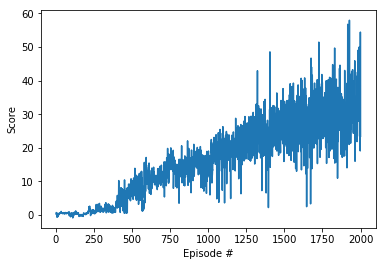

In [7]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#Inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, 
              num_agents=env_info.vector_observations.shape[0],  random_seed=0)
#Since the model is trained on gpu, need to load all gpu tensors to cpu:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location=lambda storage, loc: storage))

agent.eps = 0.05
scores_list = []
def ddpg_inference(n_episodes=300):
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        agent.reset() #reset the agent OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get rewards (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Episode {}: {}'.format(i_episode, np.mean(scores)))
        scores_list.append(np.mean(scores))
    print('Mean score is: ', np.mean(np.array(scores_list)))

ddpg_inference()

In [ ]:
env.close()